In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms


import os
from box import Box
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy import spatial


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='6'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [12]:
config = {
    'input':{
        'image_dir':'./input/kaggle_dogs'
    },
    'plot':'./plot',
    'seed':0,
    "transforms":{
        "size":(224, 224),
        "mean":(0.485, 0.456, 0.406),
        "std":(0.229, 0.224, 0.225),
    },
    'hparams':{
        'batch_size':64,
    },
}

config = Box(config)

In [13]:
def seed_torch(seed:int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(config.seed)

In [14]:
dogs_fname_list = os.listdir(config.input.image_dir)
print(f"{len(dogs_fname_list)} files")

dogs_df = pd.DataFrame(columns=['id', 'filename', 'sim'])
dogs_df['filename'] = dogs_fname_list
dogs_df['id'] = dogs_df.filename.map(lambda x: int(x[4:-4]))
dogs_df['sim'] = 0
dogs_df.sort_values('id', inplace=True)
dogs_df.reset_index(inplace=True, drop=True)
display(dogs_df)

12500 files


,id,filename,sim
0,0,dog.0.jpg,0
1,1,dog.1.jpg,0
2,2,dog.2.jpg,0
3,3,dog.3.jpg,0
4,4,dog.4.jpg,0
...,...,...,...
12495,12495,dog.12495.jpg,0
12496,12496,dog.12496.jpg,0
12497,12497,dog.12497.jpg,0
12498,12498,dog.12498.jpg,0


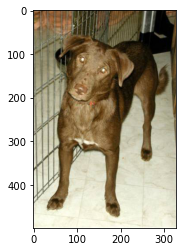

In [15]:
img_path = os.path.join(config.input.image_dir, dogs_df.loc[1, 'filename'])
img = Image.open(img_path)
plt.imshow(img)

In [18]:
class ImageTransform():
    """
    Class for image preprocessing.
    
    Attributes
    ----------
    resize : int
        224
    mean : (R, G, B)
        Average value for each color channel
    std : (R, G, B)
        Standard deviation for each color channel
    """
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                #transforms.Resize(resize),
                #transforms.CenterCrop(resize),
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                #transforms.ColorJitter(),  # Randomly change brightness, contrast, saturation, and hue. 
                #transforms.RandomAffine(degrees=[-10, 10]),  # random affine transformations.
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                #transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(resize),
                #transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'sub': transforms.Compose([
                transforms.Resize(resize),
                #transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase="train"):
        """
        Parameters
        ----------
        phase: 'train' or 'val' or 'test'
            Specify the mode of preprocessing
        """
        return self.data_transform[phase](img)

torch.Size([3, 224, 224])
tensor(2.5354) tensor(-2.1179) tensor(0.3301)


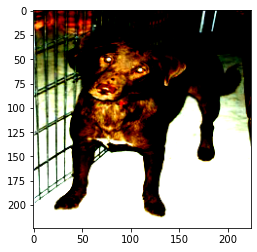

In [19]:
transform = ImageTransform(config.transforms.size, config.transforms.mean, config.transforms.std)
img_transformed_o = transform(img, phase='test')
print(img_transformed_o.shape)

print(img_transformed_o.max(), img_transformed_o.min(), img_transformed_o.mean())
img_transformed = img_transformed_o.numpy().transpose([1, 2, 0])
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)

## Dataset

In [20]:
class CustomDataset(Dataset):
    def __init__(self, df, config:dict, transform, phase='test'):
        self.df = df
        self.config = config
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Image
        img_path = os.path.join(config.input.image_dir, self.df.loc[idx, 'filename'])
        img = Image.open(img_path)
        img = self.transform(img, self.phase)

        # label
        label = torch.tensor(-1)

        # filename
        filename = self.df.loc[idx, 'filename']
        
        return img, label, filename

In [21]:
ds = CustomDataset(df=dogs_df, config=config, transform=transform, phase='test')

In [22]:
img, label, filename = ds[0]
print(f"{filename} Image:{img.shape}, Label:{label}")

dog.0.jpg Image:torch.Size([3, 224, 224]), Label:-1


## Dataloder

In [23]:
dl = DataLoader(ds, batch_size=config.hparams.batch_size, shuffle=False)

In [24]:
images, labels, filenames = next(iter(dl))
print(f"{filenames} Image:{images.shape}, Label:{labels.shape}")

('dog.0.jpg', 'dog.1.jpg', 'dog.2.jpg', 'dog.3.jpg', 'dog.4.jpg', 'dog.5.jpg', 'dog.6.jpg', 'dog.7.jpg', 'dog.8.jpg', 'dog.9.jpg', 'dog.10.jpg', 'dog.11.jpg', 'dog.12.jpg', 'dog.13.jpg', 'dog.14.jpg', 'dog.15.jpg', 'dog.16.jpg', 'dog.17.jpg', 'dog.18.jpg', 'dog.19.jpg', 'dog.20.jpg', 'dog.21.jpg', 'dog.22.jpg', 'dog.23.jpg', 'dog.24.jpg', 'dog.25.jpg', 'dog.26.jpg', 'dog.27.jpg', 'dog.28.jpg', 'dog.29.jpg', 'dog.30.jpg', 'dog.31.jpg', 'dog.32.jpg', 'dog.33.jpg', 'dog.34.jpg', 'dog.35.jpg', 'dog.36.jpg', 'dog.37.jpg', 'dog.38.jpg', 'dog.39.jpg', 'dog.40.jpg', 'dog.41.jpg', 'dog.42.jpg', 'dog.43.jpg', 'dog.44.jpg', 'dog.45.jpg', 'dog.46.jpg', 'dog.47.jpg', 'dog.48.jpg', 'dog.49.jpg', 'dog.50.jpg', 'dog.51.jpg', 'dog.52.jpg', 'dog.53.jpg', 'dog.54.jpg', 'dog.55.jpg', 'dog.56.jpg', 'dog.57.jpg', 'dog.58.jpg', 'dog.59.jpg', 'dog.60.jpg', 'dog.61.jpg', 'dog.62.jpg', 'dog.63.jpg') Image:torch.Size([64, 3, 224, 224]), Label:torch.Size([64])


## Model

In [25]:
base_model = models.vgg16(pretrained=True)

In [26]:
print(base_model.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [27]:
class CustomModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.linear = base_model.classifier[0]
        
    def forward(self, img):
        out = self.features(img)
        out = self.avgpool(out)
        out = out.view(out.shape[0], -1)
        out = self.linear(out)
        return out

In [28]:
model = CustomModel(base_model=base_model)

In [29]:
out = model(images)
print(out.shape)

torch.Size([64, 4096])


## 類似度
[コサイン類似度](https://www.delftstack.com/ja/howto/python/cosine-similarity-between-lists-python/)

In [30]:
def get_cos_sim(df, bs, target=1):
    cos_sim_list = []
    for i in range(0, bs):
        cos_sim = F.cosine_similarity(out[target], out[i], dim=0)
        cos_sim_list.append(float(cos_sim.detach().numpy()))
    df.loc[:bs-1, 'sim'] = cos_sim_list
    return df

In [31]:
dogs_df = get_cos_sim(df=dogs_df, bs=config.hparams.batch_size, target=50)

In [32]:
def plot_images_labels(df, bs):
    r = c = int(np.sqrt(bs))
    df.reset_index(inplace=True, drop=True)
    fig=plt.figure(figsize=(20, 20))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    for i in range(r * c):
        ax = fig.add_subplot(r, c, i+1)
        # Title
        fname = df.loc[df.index==i, 'filename'].values[0]
        sim = df.loc[df.index==i, 'sim'].values[0]
        if sim == 1.0:
            title = f"{fname} [Target]"
        else:
            title = f"{fname} [Sim:{sim:.2f}]"
        ax.set_title(title)
        # Images
        img_path = os.path.join(config.input.image_dir, df.loc[i, 'filename'])
        img = Image.open(img_path)
        ax.imshow(img)
    fig.savefig(os.path.join(config.plot, fname))

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


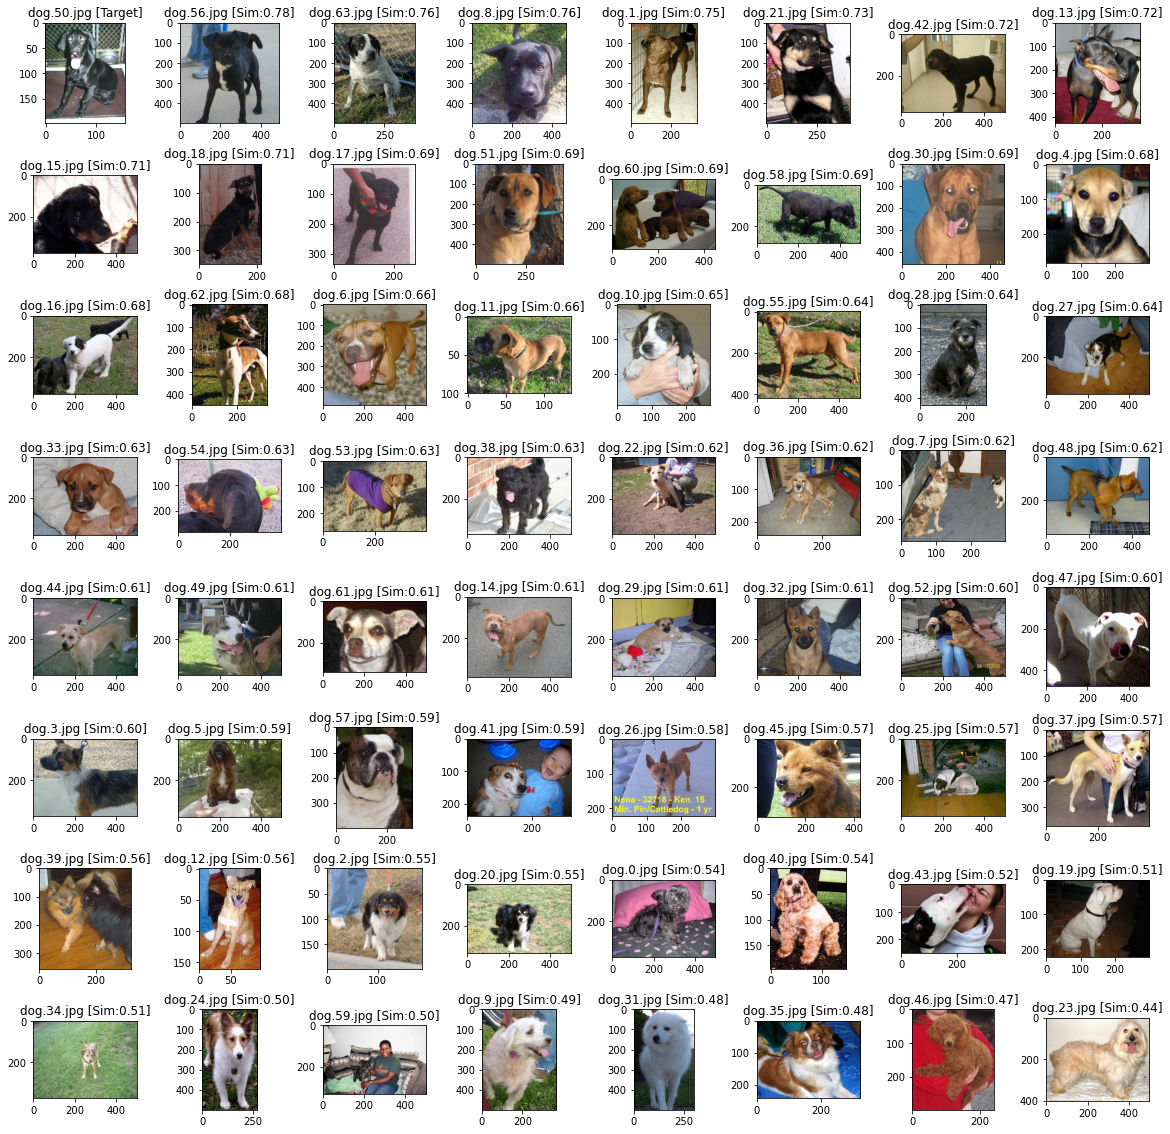

In [33]:
plot_images_labels_df = dogs_df.loc[:config.hparams.batch_size-1]
plot_images_labels_df.sort_values('sim', inplace=True, ascending=False)
plot_images_labels(df=plot_images_labels_df, bs=config.hparams.batch_size)